# Conditional Variational AutoEncoder (CVAE) on MNIST data for Image Impainting

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import tensorflow as tf
import math
from sklearn import model_selection

from keras import layers
from keras import models
from keras import Model
from keras.datasets import mnist
from keras import backend as K
from keras import metrics
from keras import optimizers

K.tensorflow_backend._get_available_gpus()

# The Function used to plot the original image and the predicted image
def Plot_Img(n,k,images,fig_w,fig_h):
    # n is how many digits we will display//
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(k, k))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def Plot_Img2(n,images,fig_w,fig_h):
    # n is how many digits we will display//
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
# The Function used to remove the middle square of the image
def Img_incomp(imgs,start=10,end=20):
    n = imgs.shape[0]
    for i in range(n):
        imgs[i][start:end,start:end] = 0
    return imgs

Using TensorFlow backend.


Data loading and normalization.

In [0]:
(x_tra, y_tra), (x_te, y_te) = mnist.load_data()

# Normalize the pixels to 0 and 1 range
x_tra = x_tra.astype('float32') / 255.
x_te = x_te.astype('float32') / 255.

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixels to 0 and 1 range
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Data preparation that remove the inner 10x10 square from the original images. What we have left is a flawed image. Our task is to use CVAE to fill this missing part.

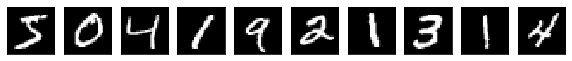

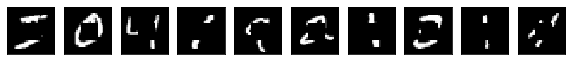

In [0]:
# Modfied training and testing imgs
x_train = Img_incomp(x_train)
x_test = Img_incomp(x_test)

# Plot some examples
Plot_Img2(10,x_tra,10,10)
Plot_Img2(10,x_train,10,10)

In [0]:
# Reshape each image matrix to a long vector
x_train = np.reshape(x_train, (len(x_train), 28*28))  
x_test = np.reshape(x_test, (len(x_test), 28*28))  
print (x_train.shape)
print (x_test.shape)

# Conditional data matrices
cond_train = np.ones((x_train.shape[0],28,28))
cond_test = np.ones((x_test.shape[0],28,28))
cond_train = Img_incomp(cond_train)
cond_test = Img_incomp(cond_test)
cond_train = np.reshape(cond_train, (len(cond_train), 28*28))  
cond_test = np.reshape(cond_test, (len(cond_test), 28*28)) 
print (cond_train.shape)
print (cond_test.shape)

(60000, 784)
(10000, 784)
(60000, 784)
(10000, 784)


Parameters, representation trick function and the loss function.

In [0]:
batch_size = 20
input_dim = 28*28
layer_dim = 512
h_dim = 20
cond_dim = cond_train.shape[1]

def csampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size,h_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

def cvae_loss(x, decode_z):
    x = K.flatten(x)
    decode_z = K.flatten(decode_z)
    xent_loss = K.sum(K.binary_crossentropy(x, decode_z), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + cvae_log_var - K.square(cvae_mu) - K.exp(cvae_log_var), axis=-1)
    return xent_loss + kl_loss

Main structure of the CVAE model.

In [0]:
# Construct the Fully-Connected CVAE model
X = layers.Input(batch_shape=(batch_size,input_dim))
cond = layers.Input(batch_shape=(batch_size,cond_dim))
cvae_Input = layers.concatenate([X,cond], axis=-1)
cvae_f1 = layers.Dense(layer_dim,activation='relu')(cvae_Input)
cvae_mu = layers.Dense(h_dim,activation='relu')(cvae_f1)
cvae_log_var = layers.Dense(h_dim,activation='relu')(cvae_f1)

# Imputed latent values
cvae_z = layers.Lambda(csampling, output_shape=(h_dim,))([cvae_mu, cvae_log_var])
cvae_z_cond = layers.concatenate([cvae_z,cond], axis=-1)

# CVAE decoder layers
cvae_decoder_f1 = layers.Dense(layer_dim,activation='relu')
cvae_decoder_out = layers.Dense(input_dim,activation='sigmoid')

# CVAE model
cvae_decoder_1 = cvae_decoder_f1(cvae_z_cond)
cvae_decoded = cvae_decoder_out(cvae_decoder_1)
cvae = Model([X,cond],cvae_decoded)
cvae.summary()

# The decoder model
cvae_z_input1 = layers.Input(batch_shape=(batch_size,h_dim))
cvae_z_input2 = layers.Input(batch_shape=(batch_size,cond_dim))
cx = layers.concatenate([cvae_z_input1,cvae_z_input2], axis=-1)
cx = cvae_decoder_f1(cx)
cx = cvae_decoder_out(cx)
cvae_decoder = Model([cvae_z_input1,cvae_z_input2],cx)
cvae_decoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (20, 784)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (20, 784)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (20, 1568)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (20, 

Train the CVAE model.

In [0]:
cvae_opt = optimizers.Adam(0.0005,0.5)
cvae.compile(optimizer=cvae_opt, loss=cvae_loss)
cvae.fit([x_train,cond_train],x_tra,epochs=50,batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 12s 196us/step - loss: 2926.0892
Epoch 2/50
60000/60000 [==============================] - 12s 204us/step - loss: 2478.2001
Epoch 3/50
60000/60000 [==============================] - 11s 186us/step - loss: 2375.7562
Epoch 4/50
60000/60000 [==============================] - 11s 186us/step - loss: 2324.7528
Epoch 5/50
60000/60000 [==============================] - 11s 186us/step - loss: 2287.9557
Epoch 6/50
60000/60000 [==============================] - 11s 185us/step - loss: 2262.3614
Epoch 7/50
60000/60000 [==============================] - 11s 185us/step - loss: 2244.0489
Epoch 8/50
60000/60000 [==============================] - 11s 185us/step - loss: 2229.4655
Epoch 9/50
60000/60000 [==============================] - 12s 204us/step - loss: 2218.4720
Epoch 10/50
60000/60000 [==============================] - 11s 185us/step - loss: 2209.7892
Epoch 11/50
60000/60000 [================

Reconstruction digits sample.

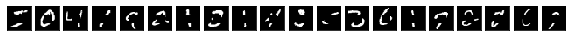

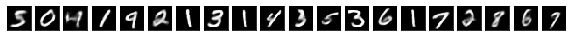

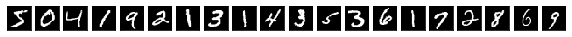

In [0]:
cvae_recons = cvae.predict([x_train,cond_train],batch_size=batch_size)
Plot_Img(20,28,x_train,10,10)
Plot_Img(20,28,cvae_recons,10,10)
Plot_Img(20,28,x_tra,10,10)
plt.show()

Test image set reconstruction.

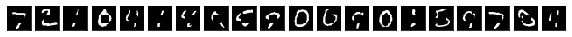

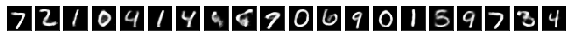

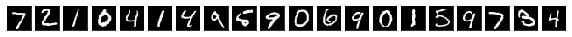

In [0]:
cvae_recons_test = cvae.predict([x_test,cond_test],batch_size=batch_size)
Plot_Img(20,28,x_test,10,10)
Plot_Img(20,28,cvae_recons_test,10,10)
Plot_Img(20,28,x_te,10,10)
plt.show()